Kết nối Mount đến Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Khai báo thư viện

In [2]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure

In [3]:
#Hàm load dữ liệu từ folder
def load_images_from_folder(folder, img_rows, img_cols):
    images = []
    labels = []
    class_names = sorted([
        d for d in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, d))
    ])

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)

            # Bỏ qua file không phải ảnh
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (img_rows, img_cols))
            images.append(img)
            labels.append(label)

    return images, labels, class_names


In [4]:
import os
import numpy as np

# Đọc dữ liệu từ thư mục Dataset đã chia sẵn
base_data_path = "/content/drive/MyDrive/split_data"
img_rows, img_cols = 128, 128

# Load training data
print("Đang tải dữ liệu Training...")
X_train_list, y_train_list, class_names = load_images_from_folder(
    os.path.join(base_data_path, "train"), img_rows, img_cols
)
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
print(f"Số ảnh Training: {len(X_train)}")
print(f"Số label Training: {len(y_train)}")

# Load validation data
print("\nĐang tải dữ liệu Validation...")
X_val_list, y_val_list, _ = load_images_from_folder(
    os.path.join(base_data_path, "validation"), img_rows, img_cols
)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
print(f"Số ảnh Validation: {len(X_val)}")
print(f"Số label Validation: {len(y_val)}")

# Load test data
print("\nĐang tải dữ liệu Test...")
X_test_list, y_test_list, _ = load_images_from_folder(
    os.path.join(base_data_path, "test"), img_rows, img_cols
)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)
print(f"Số ảnh Test: {len(X_test)}")
print(f"Số label Test: {len(y_test)}")

print("\nTên lớp:", class_names)

Đang tải dữ liệu Training...
Số ảnh Training: 4471
Số label Training: 4471

Đang tải dữ liệu Validation...
Số ảnh Validation: 558
Số label Validation: 558

Đang tải dữ liệu Test...
Số ảnh Test: 558
Số label Test: 558

Tên lớp: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [5]:
#Trích xuất đặc trưng hog
def extract_hog_features(images):
    hog_features = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        hog_features.append(features)

    return np.array(hog_features)

In [6]:
X_train_hog = extract_hog_features(X_train)
X_val_hog   = extract_hog_features(X_val)
X_test_hog  = extract_hog_features(X_test)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_val_hog_scaled = scaler.transform(X_val_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Định nghĩa lưới tham số cho GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  # Số lượng cây trong rừng
    'max_depth': [None, 10, 20],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5],  # Số mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2]  # Số mẫu tối thiểu yêu cầu cho một lá
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # Số lần cross-validation
    n_jobs=-1,  # Sử dụng tất cả các lõi CPU có thể
    verbose=2,  # Hiển thị thông tin chi tiết trong quá trình tìm kiếm
    scoring='accuracy' # Tiêu chí đánh giá
)


grid_search.fit(X_train_hog_scaled, y_train)

# In ra các tham số tốt nhất và điểm số tốt nhất
print("\nTham số tốt nhất tìm được:", grid_search.best_params_)
print("Điểm số tốt nhất (độ chính xác trên tập validation):", grid_search.best_score_)



Fitting 3 folds for each of 36 candidates, totalling 108 fits

Tham số tốt nhất tìm được: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Điểm số tốt nhất (độ chính xác trên tập validation): 0.6846327780253482


In [9]:
# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập test
y_pred_rf = best_rf_model.predict(X_test_hog_scaled)

print("\nBáo cáo phân loại trên tập test:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))
print("Độ chính xác trên tập test:", accuracy_score(y_test, y_pred_rf))


Báo cáo phân loại trên tập test:
                precision    recall  f1-score   support

Auto Rickshaws       0.78      0.50      0.61        80
         Bikes       0.96      0.89      0.92        80
          Cars       0.77      0.63      0.69        79
   Motorcycles       0.80      0.74      0.77        80
        Planes       0.80      0.70      0.74        79
         Ships       0.50      0.80      0.62        80
        Trains       0.58      0.71      0.64        80

      accuracy                           0.71       558
     macro avg       0.74      0.71      0.71       558
  weighted avg       0.74      0.71      0.71       558

Độ chính xác trên tập test: 0.7096774193548387


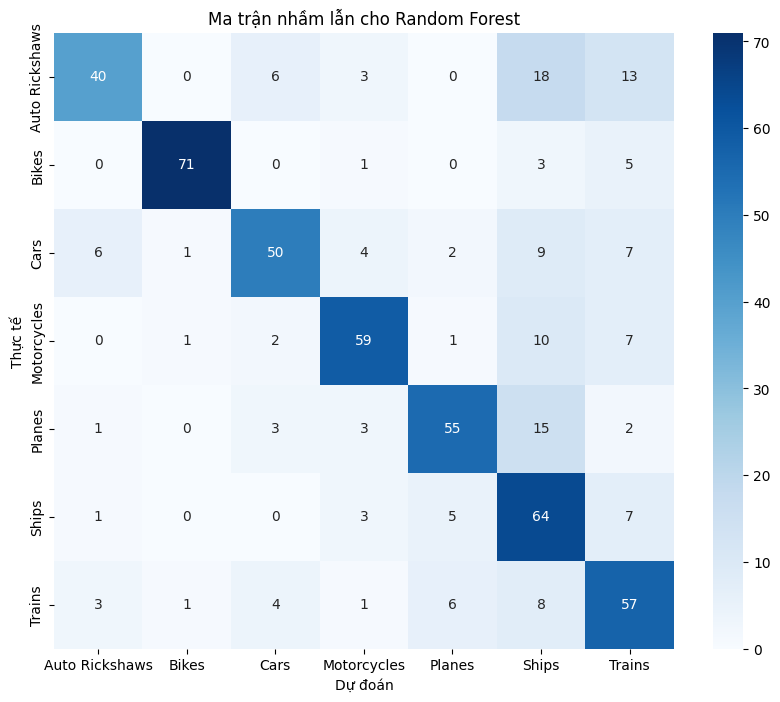

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# In Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn cho Random Forest')
plt.show()